This file contains activation and gradients magnitudes analysis

## Imports

In [ ]:
pip install fast-pytorch-kmeans

In [ ]:
from google.colab import drive
import numpy as np
import torch
from safetensors.torch import save_file,load_file

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
data=load_file("drive/MyDrive/layer31_nb64split07b.safetensors")

In [ ]:
acts_k = data["acts_k"]
grads2_k = data["grads_k"]
acts_v = data["acts_v"]
grads2_v = data["grads_v"]


In [ ]:
means_k = (grads2_k*(acts_k**2)).mean(dim=(0,2))
means_v = (grads2_v*(acts_v**2)).mean(dim=(0,2))

## Gradients and activations magnitudes

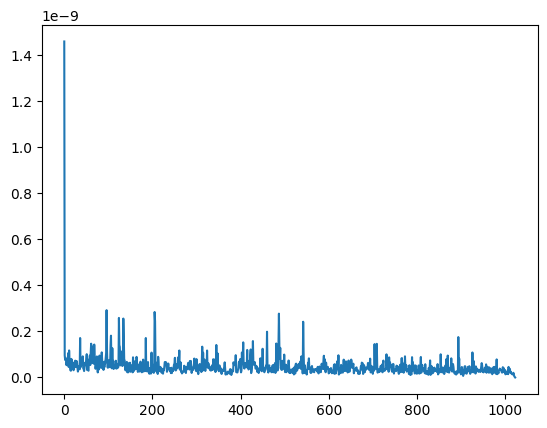

In [ ]:
plt.plot(np.array(means_k))

In [ ]:
np.array(means_k)

array([1.8210211e-09, 4.0490212e-11, 3.9020339e-11, ..., 3.8583679e-13,
       2.1321710e-13, 0.0000000e+00], dtype=float32)

## 3D Keys/Values Magnitude breakdown

In [ ]:
import torch.nn as nn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

def plot_acts(acts):

  ### Plotting function for activation magnitude plots used in the thesis Preliminary Experiments section

  data = np.abs(acts).mean(dim=0).transpose(1,0)  # shape: (tokens, channels)
  tokens = data.shape[0]
  channels = data.shape[1]

  step = 4

  x = np.arange(0, tokens, step)
  y = np.arange(0, channels, step)
  X, Y = np.meshgrid(x, y, indexing='ij')

  x_flat = X.ravel()
  y_flat = Y.ravel()
  z_bottom = np.zeros_like(x_flat)
  z_top = data[x_flat, y_flat]/2

  segments = np.stack([
      np.stack([x_flat, y_flat, z_bottom], axis=1),
      np.stack([x_flat, y_flat, z_top], axis=1)
  ], axis=1)  # shape: (n_segments, 2, 3)

  norm = plt.Normalize(vmin=z_top.min(), vmax=z_top.max())
  cmap = cm.get_cmap('coolwarm')  # blue to red
  colors = cmap(norm(z_top))

  lc = Line3DCollection(segments, colors=colors, linewidths=0.5, alpha=1.)

  fig = plt.figure(figsize=(10*0.9, 8*0.9))
  ax = fig.add_subplot(111, projection='3d')
  ax.add_collection3d(lc)

  ax.set_xlim(0, tokens)
  ax.set_ylim(0, channels)
  ax.set_zlim(0, np.percentile(data, 99))

  ax.set_xlabel('Channel')
  ax.set_ylabel('Token')
  ax.set_zlabel('Magnitude')

  plt.tight_layout()
  plt.show()


In [ ]:
### Functions taken from Llama models in HF's transformers library

class LlamaRotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None):
        super().__init__()

        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (self.base ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float().to(device) / self.dim))
        self.register_buffer("inv_freq", inv_freq, persistent=False)

        # Build here to make `torch.jit.trace` work.
        self._set_cos_sin_cache(
            seq_len=max_position_embeddings, device=self.inv_freq.device, dtype=torch.get_default_dtype()
        )

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=torch.int64).type_as(self.inv_freq)

        freqs = torch.outer(t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len=None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        if seq_len > self.max_seq_len_cached:
            self._set_cos_sin_cache(seq_len=seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype),
        )

class LlamaLinearScalingRotaryEmbedding(LlamaRotaryEmbedding):
    """LlamaRotaryEmbedding extended with linear scaling. Credits to the Reddit user /u/kaiokendev"""

    def __init__(self, dim, max_position_embeddings=2048, base=10000, device=None, scaling_factor=1.0):
        self.scaling_factor = scaling_factor
        super().__init__(dim, max_position_embeddings, base, device)

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        t = torch.arange(self.max_seq_len_cached, device=device, dtype=torch.int64).type_as(self.inv_freq)
        t = t / self.scaling_factor

        freqs = torch.outer(t, self.inv_freq)
        # Different from paper, but it uses a different permutation in order to obtain the same calculation
        emb = torch.cat((freqs, freqs), dim=-1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(k, cos, sin, position_ids, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`):
            The position indices of the tokens corresponding to the query and key tensors. For example, this can be
            used to pass offsetted position ids when working with a KV-cache.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    position_ids = position_ids.cpu()
    cos = cos[position_ids].unsqueeze(unsqueeze_dim).unsqueeze(0)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim).unsqueeze(0)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return k_embed

In [ ]:
def apply_linear_rope(k, n_heads):
    # (bsz,seqlen,totaldim)
    bsz, seqlen, totaldim = k.shape
    head_dim = totaldim//n_heads
    k = k.reshape(bsz, seqlen, n_heads, head_dim).transpose(2, 1)
    RotEmb = LlamaLinearScalingRotaryEmbedding(head_dim, base=1000)
    RotEmb._set_cos_sin_cache(seqlen, torch.device("cpu"), torch.float32)
    cos, sin = RotEmb(k, seqlen)
    k_roped = apply_rotary_pos_emb(
        k, cos, sin, torch.arange(seqlen), unsqueeze_dim=0)
    return k_roped.transpose(1, 2).flatten(2, 3)


In [ ]:
acts_k_roped = apply_linear_rope(acts_k, 32)


/tmp/ipython-input-6-168943729.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data = np.abs(acts).mean(dim=0).transpose(1,0)  # shape: (tokens, channels)
/tmp/ipython-input-6-168943729.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # blue to red


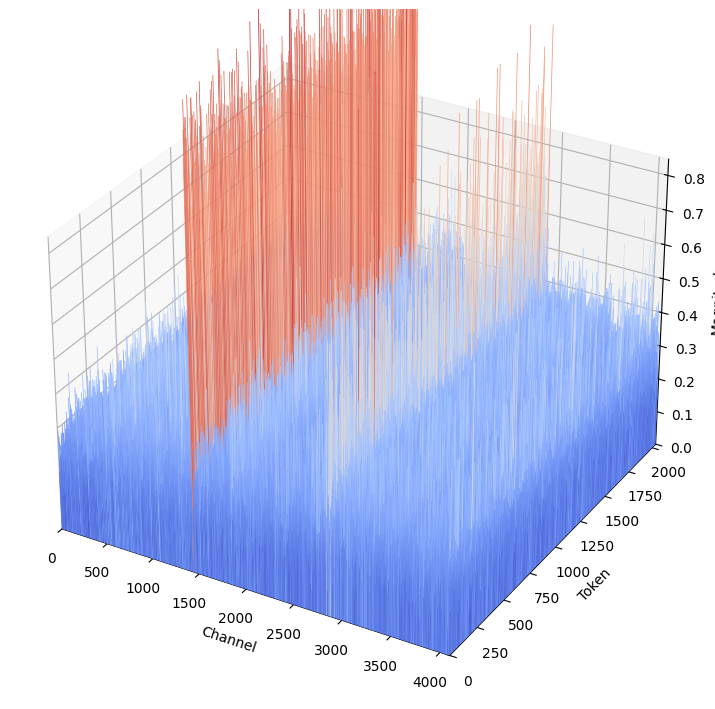

In [ ]:
plot_acts(acts_v[:,10:,:])

/tmp/ipython-input-54-168943729.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  data = np.abs(acts).mean(dim=0).transpose(1,0)  # shape: (tokens, channels)
/tmp/ipython-input-54-168943729.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # blue to red


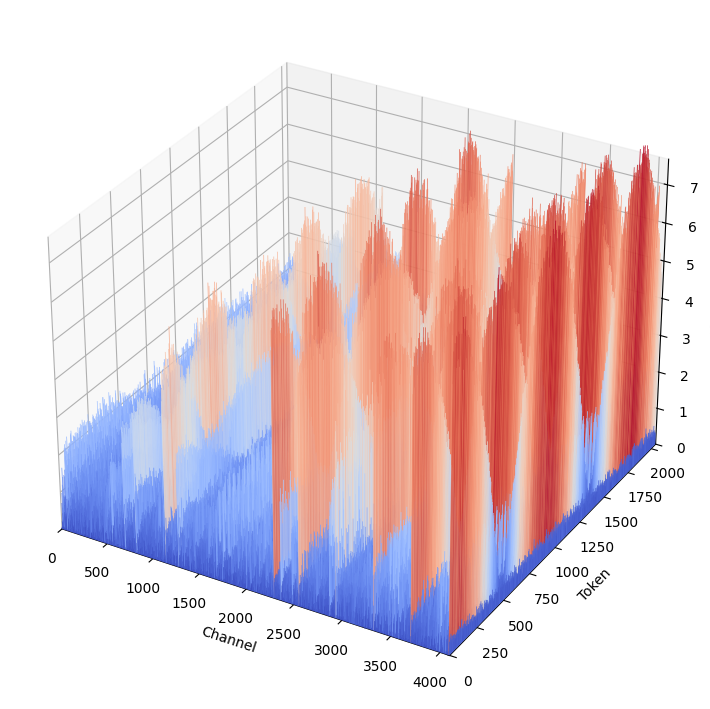

In [ ]:
plot_acts(acts_k_roped)